C:\Users\jesus\AppData\Local\Temp\ipykernel_27156\2600502282.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{feature}_lag_{lag}"] = data[feature].shift(lag)
C:\Users\jesus\AppData\Local\Temp\ipykernel_27156\2600502282.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{feature}_lag_{lag}"] = data[feature].shift(lag)
C:\Users\jesus\AppData\Local\Temp\ipykernel_27156\2600502282.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

RMSE: 248.1146
MAE: 11.7908
R²: -0.6756


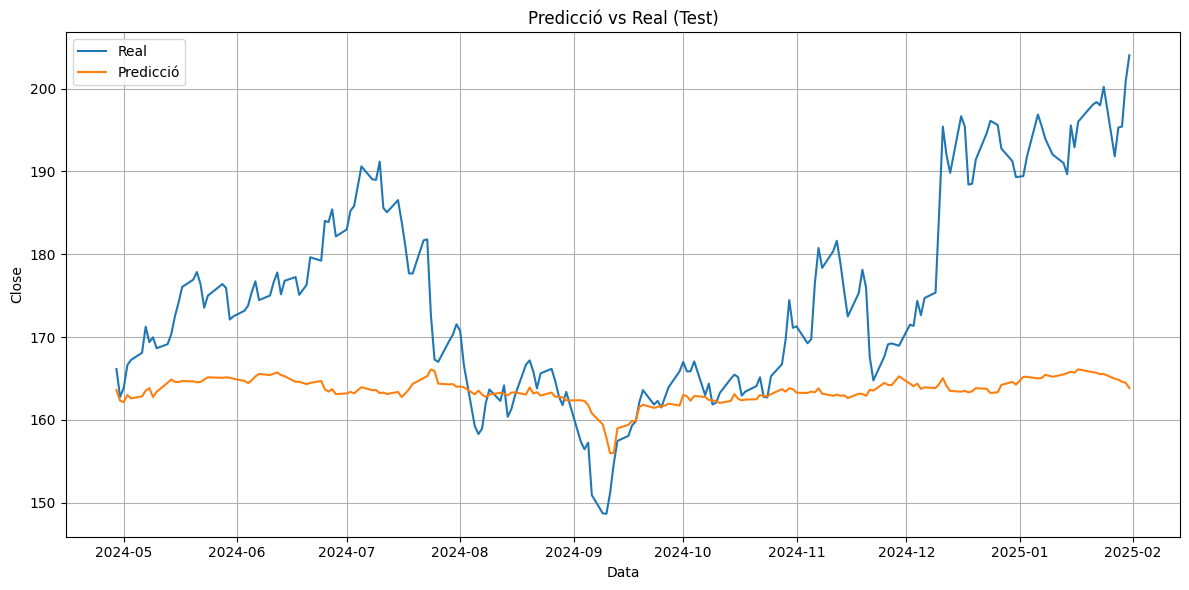

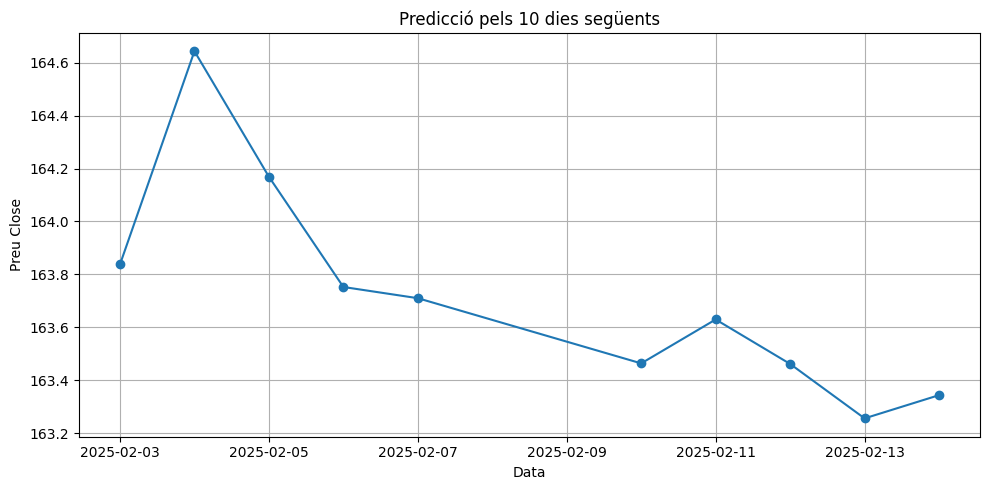

In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Carregar dades
data = pd.read_csv("Conjunt de dades Preprocessades/Datasets/Google_Stock_Price_output.csv")

if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    dates = data['Date']
    data = data.drop(columns=['Date'])
else:
    dates = pd.date_range(start='2020-01-01', periods=len(data), freq='B')

# Definir característiques
features = ["Open", "High", "Low", "Volume", "EMA_7", "EMA_40",
            "MACD", "Signal_Line", "MACD_Hist", "RSI", "ATR"]
target_col = "Close"

# Normalització separada
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

data[features] = feature_scaler.fit_transform(data[features])
data[target_col] = target_scaler.fit_transform(data[[target_col]])

# Crear lags
lag_days = 10
for lag in range(1, lag_days + 1):
    for feature in features + [target_col]:
        data[f"{feature}_lag_{lag}"] = data[feature].shift(lag)

data.dropna(inplace=True)
dates = dates[-len(data):]

# Divisió temporal
train_end = int(len(data) * 0.7)
val_end = int(len(data) * 0.85)

X = data.drop(columns=[target_col])
y = data[target_col]

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]
test_dates = dates[val_end:]

# Optimització
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1
)

X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])
grid_search.fit(X_trainval, y_trainval)
model = grid_search.best_estimator_

# Predicció i mètriques
y_pred = model.predict(X_test)
y_test_real = target_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
y_pred_real = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

rmse = mean_squared_error(y_test_real, y_pred_real)
mae = mean_absolute_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Gràfica test
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_real, label="Real")
plt.plot(test_dates, y_pred_real, label="Predicció")
plt.title("Predicció vs Real (Test)")
plt.xlabel("Data")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicció 10 dies futurs
last_row = data.iloc[-1:]
future_predictions = []
current_features = last_row.copy()

for i in range(10):
    pred = model.predict(current_features.drop(columns=[target_col]))[0]
    future_predictions.append(pred)

    # Actualitzar lags
    new_row = current_features.copy()
    for feature in features + [target_col]:
        for lag in range(lag_days, 1, -1):
            new_row[f"{feature}_lag_{lag}"] = new_row[f"{feature}_lag_{lag - 1}"]
        new_row[f"{feature}_lag_1"] = new_row[feature].values[0]
    new_row[target_col] = pred
    current_features = new_row

# Desnormalitzar prediccions futures
future_predictions_real = target_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()
future_dates = pd.date_range(start=dates.iloc[-1] + pd.Timedelta(days=1), periods=10, freq='B')
future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Close": future_predictions_real
})

# Gràfica prediccions futures
plt.figure(figsize=(10, 5))
plt.plot(future_df["Date"], future_df["Predicted_Close"], marker='o')
plt.title("Predicció pels 10 dies següents")
plt.xlabel("Data")
plt.ylabel("Preu Close")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Carregar dades
df = pd.read_csv("Conjunt de dades Preprocessades/Datasets/Merged_Stock_Dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(["Asset", "Date"]).reset_index(drop=True)

features = ["Open", "High", "Low", "Volume", "EMA_7", "EMA_40",
            "MACD", "Signal_Line", "MACD_Hist", "RSI", "ATR"]
target_col = "Close"
lag_days = 10

# Preprocessar per asset: normalització i lags
scalers = {}
all_data = []

for asset in df['Asset'].unique():
    sub_df = df[df['Asset'] == asset].copy()
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    sub_df[features] = feature_scaler.fit_transform(sub_df[features])
    sub_df[target_col] = target_scaler.fit_transform(sub_df[[target_col]])
    scalers[asset] = target_scaler

    for lag in range(1, lag_days + 1):
        for feature in features + [target_col]:
            sub_df[f"{feature}_lag_{lag}"] = sub_df[feature].shift(lag)

    sub_df.dropna(inplace=True)
    all_data.append(sub_df)

data_all = pd.concat(all_data).sort_values("Date").reset_index(drop=True)
dates_all = data_all['Date']
assets_all = data_all['Asset']
data_all = data_all.drop(columns=['Date', 'Asset'])

# Separar dades per entrenament/validació/test
train_idx = []
val_idx = []
test_idx = []

for asset in np.unique(assets_all):
    idxs = np.where(assets_all == asset)[0]
    n = len(idxs)
    tr_end = int(n * 0.7)
    vl_end = tr_end + int(n * 0.15)
    train_idx.extend(idxs[:tr_end])
    val_idx.extend(idxs[tr_end:vl_end])
    test_idx.extend(idxs[vl_end:])

X = data_all.drop(columns=[target_col])
y = data_all[target_col]

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
X_val = X.iloc[val_idx]
y_val = y.iloc[val_idx]
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]
test_dates = dates_all.iloc[test_idx]
test_assets = assets_all.iloc[test_idx]

# PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Optimització amb GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train_pca, y_train)
model = grid_search.best_estimator_
print("Millors hiperparàmetres trobats:", grid_search.best_params_)

# Avaluació
y_val_pred = model.predict(X_val_pca)
y_test_pred = model.predict(X_test_pca)

val_rmse = mean_squared_error(y_val, y_val_pred)
test_rmse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"VALIDACIÓ - RMSE: {val_rmse:.4f}")
print(f"TEST - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

# Guardar prediccions test
results_df = pd.DataFrame({
    "Date": test_dates.values,
    "Asset": test_assets.values,
    "Predicted_Close_Norm": y_test_pred,
    "Actual_Close_Norm": y_test.values
})

# Desnormalitzar
def desnormalize(pred_scaled, scaler, feature_idx):
    dummy = np.zeros((1, len(features)))
    dummy[0, feature_idx] = pred_scaled
    inv = scaler.inverse_transform(dummy)
    return inv[0, feature_idx]

feature_idx = 0  # index fixat per la funció desnormalize
final_results = []

for asset in results_df['Asset'].unique():
    subset = results_df[results_df['Asset'] == asset].copy()
    scaler = scalers[asset]
    subset["Predicted_Close"] = scaler.inverse_transform(subset[["Predicted_Close_Norm"]])
    subset["Actual_Close"] = scaler.inverse_transform(subset[["Actual_Close_Norm"]])
    final_results.append(subset[["Date", "Asset", "Predicted_Close", "Actual_Close"]])

final_df = pd.concat(final_results).sort_values(["Asset", "Date"])
final_df.to_csv("Prediccions_Test_RF_Per_Empresa.csv", index=False)

# Forward Forecasting
last_sequences = defaultdict(list)
for i, asset in enumerate(assets_all[test_idx]):
    last_sequences[asset].append(X_test.iloc[i])

for asset in last_sequences:
    last_sequences[asset] = last_sequences[asset][-1]

future_days = 10
future_predictions = []

for asset, seq in last_sequences.items():
    scaler = scalers[asset]
    sequence = seq.copy().values
    preds_scaled = []
    future_dates = []
    last_date = df[df["Asset"] == asset]["Date"].max()

    for i in range(future_days):
        seq_pca = pca.transform(sequence.reshape(1, -1))
        pred_scaled = model.predict(seq_pca)[0]
        preds_scaled.append(pred_scaled)
        new_step = sequence.copy()
        close_lag_1_index = X.columns.get_loc("Close_lag_1")
        new_step[close_lag_1_index] = pred_scaled
        sequence = new_step
        future_dates.append((last_date + pd.Timedelta(days=i+1)).strftime('%Y-%m-%d'))

    preds_original = [desnormalize(p, scaler, feature_idx) for p in preds_scaled]
    df_pred = pd.DataFrame({
        'Asset': asset,
        'Date': future_dates,
        'Predicted_Close': preds_original
    })
    future_predictions.append(df_pred)

future_predictions_df = pd.concat(future_predictions, ignore_index=True)
future_predictions_df.to_csv("Future_Predictions_All_Assets_RF.csv", index=False)
print("Prediccions futures desades a 'Future_Predictions_All_Assets_RF.csv'")

# Gràfics
for asset in future_predictions_df['Asset'].unique():
    df_pred_asset = future_predictions_df[future_predictions_df['Asset'] == asset].sort_values('Date')
    dates_pred = pd.to_datetime(df_pred_asset['Date'])
    close_pred = df_pred_asset['Predicted_Close'].values

    plt.figure(figsize=(10,5))
    plt.plot(dates_pred, close_pred, marker='o', linestyle='-', color='tab:blue')
    plt.title(f'Prediccions futures - {asset}')
    plt.xlabel('Data')
    plt.ylabel('Preu Close')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'Prediccions_Futures_Asset22_{asset}_RF.png')
    plt.close()


C:\Users\jesus\AppData\Local\Temp\ipykernel_27156\945874865.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[f"{feature}_lag_{lag}"] = sub_df[feature].shift(lag)
C:\Users\jesus\AppData\Local\Temp\ipykernel_27156\945874865.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[f"{feature}_lag_{lag}"] = sub_df[feature].shift(lag)
C:\Users\jesus\AppData\Local\Temp\ipykernel_27156\945874865.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Millors hiperparàmetres trobats: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
VALIDACIÓ - RMSE: 0.0025
TEST - RMSE: 0.0225, MAE: 0.1290, R²: 0.4729


c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature na

Prediccions futures desades a 'Future_Predictions_All_Assets_RF.csv'
